<a href="https://colab.research.google.com/github/freeexotic/competition/blob/main/Kc_crypto_bull_prediction_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q pandas_ta
!pip install catboost
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
import pandas_ta as ta
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 2.7 MB/s eta 0:00:00


In [ ]:
sample_submission = pd.read_csv("/content/drive/MyDrive/Kaggle competition/crypto-bull-prediction-challenge/sample_submission.csv")
test = pd.read_csv("/content/drive/MyDrive/Kaggle competition/crypto-bull-prediction-challenge/test.csv")
train = pd.read_csv("/content/drive/MyDrive/Kaggle competition/crypto-bull-prediction-challenge/train.csv")

In [ ]:
train.groupby('symbol').agg({"close":"max", "date":"max"}).reset_index()

,symbol,close,date
0,1000LUNC-USDT-PERP,0.473200,2023-06-30 23:00:00
1,1000SHIB-USDT-PERP,0.085878,2023-06-30 23:00:00
2,1000XEC-USDT-PERP,0.269710,2023-06-30 23:00:00
3,1INCH-USDT-PERP,7.777800,2023-06-30 23:00:00
4,AAVE-USDT-PERP,657.109985,2023-06-30 23:00:00
...,...,...,...
168,YFI-USDT-PERP,90721.296875,2023-06-30 23:00:00
169,ZEC-USDT-PERP,365.399994,2023-06-30 23:00:00
170,ZEN-USDT-PERP,166.416000,2023-06-30 23:00:00
171,ZIL-USDT-PERP,0.249060,2023-06-30 23:00:00


In [ ]:
test.groupby('symbol')['date'].min()

symbol
ADA-USDT-PERP      2023-07-01 00:00:00
AVAX-USDT-PERP     2023-07-01 00:00:00
BCH-USDT-PERP      2023-07-01 00:00:00
BNB-USDT-PERP      2023-07-01 00:00:00
BTC-USDT-PERP      2023-07-01 00:00:00
DOGE-USDT-PERP     2023-07-01 00:00:00
DOT-USDT-PERP      2023-07-01 00:00:00
ETC-USDT-PERP      2023-07-01 00:00:00
ETH-USDT-PERP      2023-07-01 00:00:00
LINK-USDT-PERP     2023-07-01 00:00:00
LTC-USDT-PERP      2023-07-01 00:00:00
MATIC-USDT-PERP    2023-07-01 00:00:00
TRX-USDT-PERP      2023-07-01 00:00:00
XRP-USDT-PERP      2023-07-01 00:00:00
Name: date, dtype: object

In [ ]:
print(len(train['symbol'].unique()),"\n")
print(train.target.value_counts(), "\n")

173 

target
0    2273961
1     821357
Name: count, dtype: int64 



In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095318 entries, 0 to 3095317
Data columns (total 10 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   symbol          object 
 2   open            float64
 3   high            float64
 4   low             float64
 5   close           float64
 6   volume          float64
 7   trades          int64  
 8   close_unixtime  float64
 9   target          int64  
dtypes: float64(6), int64(2), object(2)
memory usage: 236.2+ MB


In [ ]:
# препроцессинг данных

train['sample'] = 1 # note where we have train
test['sample'] = 0 # note where you have a test

train['id'] = 0
test['target'] = 0 # in case you don't have the value "target", we will continue the display anyway, because it's just polar zeros

data = pd.concat([train, test]).reset_index(drop=True) # concat

In [ ]:
def gen_indicators(data, indicator_periods = [2, 3, 4, 6, 9, 12, 24, 48, 72, 96, 120, 168]):
        stock_data_tech = data.copy()
        stock_data_tech = stock_data_tech.sort_values(by='date')

        fe_df = pd.DataFrame()

        i=0

        for symbol in tqdm(stock_data_tech.symbol.unique()):
            data = stock_data_tech[stock_data_tech.symbol == symbol].copy()

            data.reset_index(inplace=True, drop=True)
            data.set_index('date', drop=False, inplace=True)

            ################## Base pct ################################################################
            for period in ([1,] + indicator_periods):
                data[f'pct_close_{period}'] = data['close'].pct_change(period)

            ################### indicators ############################################################
            # none period indicators
            data.ta.pvol(append=True)
            data.ta.bop(append=True)

            for period in indicator_periods:

                if period > 2:
                    data.ta.willr(length=period, append=True)
                    data.ta.stoch(length=period, append=True)
                    data.ta.rsi(length=period, append=True)
                    data.ta.roc(length=period, append=True)
                    data.ta.mfi(length=period, append=True)
                    # data.ta.massi(length=period, append=True)  # EMA data leak !!!

            data.fillna(method="ffill", inplace=True)
            data.dropna(inplace=True)
            #data.fillna(method="bfill", inplace=True)
            #data.fillna(0, inplace=True)
            data.reset_index(inplace=True, drop=True)

            fe_df = pd.concat([fe_df, data], axis=0)
        fe_df.reset_index(inplace=True, drop=True)
        return fe_df

In [ ]:
fe_data = gen_indicators(data)

100%|██████████| 173/173 [03:40<00:00,  1.27s/it]


In [ ]:
fe_data

,date,symbol,open,high,low,close,volume,trades,close_unixtime,target,...,ROC_96,MFI_96,WILLR_120,RSI_120,ROC_120,MFI_120,WILLR_168,RSI_168,ROC_168,MFI_168
0,2019-09-15 17:00:00,BTC-USDT-PERP,10302.110352,10315.639648,10286.879883,10309.030273,889.178,1048,1.568570e+09,0,...,2.532223,43.478732,-24.937176,52.485302,0.933451,42.652026,-28.163259,52.650094,3.090303,44.148390
1,2019-09-15 18:00:00,BTC-USDT-PERP,10309.110352,10310.040039,10284.250000,10289.349609,903.340,1027,1.568574e+09,0,...,2.196514,42.507004,-28.415430,52.030707,0.893093,42.348322,-31.492022,52.277823,2.893496,43.783814
2,2019-09-15 19:00:00,BTC-USDT-PERP,10288.589844,10304.860352,10280.139648,10294.679688,844.374,988,1.568578e+09,0,...,2.154085,42.431620,-27.473421,52.143909,2.674099,42.155327,-30.590499,52.369579,-0.439457,43.204279
3,2019-09-15 20:00:00,BTC-USDT-PERP,10294.459961,10310.950195,10265.320312,10269.309570,780.407,1022,1.568581e+09,0,...,1.647447,41.470074,-31.957197,51.559893,2.054943,41.932224,-34.881570,51.891838,-0.793228,42.595056
4,2019-09-15 21:00:00,BTC-USDT-PERP,10271.190430,10304.559570,10266.129883,10289.030273,834.126,1003,1.568585e+09,0,...,1.254937,41.641284,-28.471867,51.981458,1.790360,42.215955,-31.546034,52.232589,-0.989907,42.667377
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3107368,2023-06-30 19:00:00,RDNT-USDT-PERP,0.294700,0.295700,0.291400,0.291500,3963388.000,7147,1.688155e+09,0,...,-1.420362,49.904956,-46.842103,50.993589,-0.850339,48.902354,-46.842103,51.059503,4.181560,50.789735
3107369,2023-06-30 20:00:00,RDNT-USDT-PERP,0.291400,0.292500,0.290300,0.290600,2618610.000,5329,1.688159e+09,0,...,-1.923723,48.609523,-48.421052,50.840169,-1.122835,48.321143,-48.421052,50.945502,2.976610,50.611996
3107370,2023-06-30 21:00:00,RDNT-USDT-PERP,0.290600,0.293400,0.290400,0.293400,2288769.000,4675,1.688162e+09,0,...,-0.677049,49.169578,-43.508791,51.299837,-1.378159,48.185940,-43.508791,51.285905,5.767845,50.840893
3107371,2023-06-30 22:00:00,RDNT-USDT-PERP,0.293500,0.294700,0.292600,0.293700,1371555.000,3054,1.688166e+09,0,...,-1.144395,49.567052,-42.982440,51.348990,-1.244112,47.913937,-42.982440,51.322316,5.571535,50.966577


In [ ]:
fe_train = fe_data.query('sample == 1').drop(['sample',], axis=1)
fe_test = fe_data.query('sample == 0').drop(['sample',], axis=1)

In [ ]:
fe_test = fe_test.sort_values(by=['id',])

print(fe_test[['date', 'symbol', 'trades', 'id', 'target',]])

                       date         symbol  trades     id  target
359856  2023-07-01 00:00:00  ADA-USDT-PERP   19648      1       0
359857  2023-07-01 01:00:00  ADA-USDT-PERP   32223      2       0
359858  2023-07-01 02:00:00  ADA-USDT-PERP   20769      3       0
359859  2023-07-01 03:00:00  ADA-USDT-PERP   12107      4       0
359860  2023-07-01 04:00:00  ADA-USDT-PERP   23885      5       0
...                     ...            ...     ...    ...     ...
137415  2023-10-31 04:00:00  XRP-USDT-PERP   20523  41115       0
137416  2023-10-31 05:00:00  XRP-USDT-PERP   25485  41116       0
137417  2023-10-31 06:00:00  XRP-USDT-PERP   32615  41117       0
137418  2023-10-31 07:00:00  XRP-USDT-PERP   37093  41118       0
137419  2023-10-31 08:00:00  XRP-USDT-PERP   43785  41119       0

[41119 rows x 5 columns]


In [ ]:
X_train = fe_train.drop(['open', 'high', 'low', 'close', 'volume', 'trades', 'symbol', 'date', 'id', 'target', 'close_unixtime'], axis=1)
y_train = fe_train.target.values

X_test = fe_test.drop(['open', 'high', 'low', 'close', 'volume', 'trades', 'symbol', 'date', 'id', 'target', 'close_unixtime'], axis=1)

In [ ]:
model = CatBoostClassifier(verbose=100)
model.fit(X_train, y_train,)

Learning rate set to 0.31748
0:	learn: 0.6232577	total: 1.82s	remaining: 30m 20s
100:	learn: 0.5485324	total: 2m 2s	remaining: 18m 14s
200:	learn: 0.5436823	total: 4m 5s	remaining: 16m 13s
300:	learn: 0.5400064	total: 6m 3s	remaining: 14m 4s
400:	learn: 0.5369661	total: 8m 2s	remaining: 12m
500:	learn: 0.5341447	total: 10m 2s	remaining: 10m
600:	learn: 0.5316366	total: 12m 3s	remaining: 8m
700:	learn: 0.5294399	total: 14m 3s	remaining: 5m 59s
800:	learn: 0.5272822	total: 16m 3s	remaining: 3m 59s
900:	learn: 0.5253154	total: 18m 3s	remaining: 1m 59s
999:	learn: 0.5233910	total: 20m 3s	remaining: 0us


In [ ]:
feature_importances = model.get_feature_importance()

# Создаем DataFrame для удобства
features_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Сортируем по убыванию важности
sorted_features_df = features_df.sort_values(by='Importance', ascending=False).head(25)

In [ ]:
predict_proba = model.predict_proba(X_test)[:, 1]
sample_submission['target'] = predict_proba

In [ ]:
def planka(x, i):
  if x >= i:
     x = 1
  else:
    x = 0
  return x

In [ ]:
sample_submission['id'] = test['id']

In [ ]:
sample_submission

,target,id
0,0.230159,1
1,0.242612,2
2,0.208952,3
3,0.228396,4
4,0.239068,5
...,...,...
41114,0.133268,41115
41115,0.162502,41116
41116,0.178274,41117
41117,0.133909,41118


In [ ]:
sample_submission1 = pd.DataFrame(sample_submission.target.apply(lambda x: planka(x, 0.123)))

In [ ]:
sample_submission1['id'] = test['id']

In [ ]:
sample_submission1.to_csv('submission123.csv', index=False)

<Axes: >

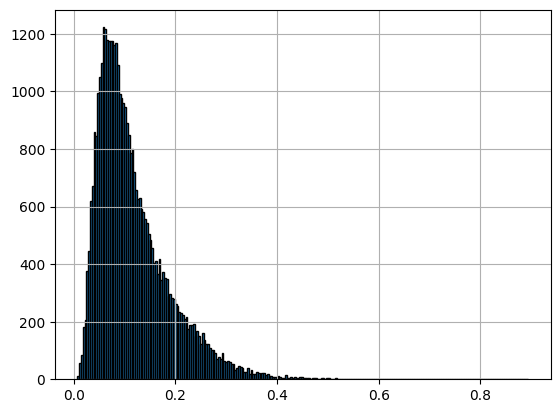

In [ ]:
sample_submission['target'].hist(bins=250, edgecolor='black')